# Spectral Sounds: Unveiling Music Genre Classification Through Audio Spectrograms

# Introduction:
With the dominance of digital music streaming, music genre classification is an increasingly important way to develop algorithms for suggesting new songs to users. Without a way to analyze the abstract aspects of each song such as mood and tone, these algorithms must be able to make accurate predictions based only on the quantitative characteristics of the audio itself.

Hence, we aim to answer the following research question:
 **Can we predict the genre of a song based on its audio spectrograph information?** In particular, we will focus on the **classical, jazz, pop, and rock music** genres.

### Dataset Description
We will be using the Music Genre Classification dataset by Andrada on [Kaggle](https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification). It includes observations for 1000 30-second audio snippets (.wav ), with 60 relevant variables that describe mean and variance values of different aspects of its audio spectrogram (visual waveform) labeled with the corresponding genre of music. Due to the number of predictor variables, we only choose a few potentially important predictors to focus on for the preliminary analysis (explanation in [Methods](#Methods) section).


## Preliminary Data Analysis

### Setting Up Libraries and Parameters

In [1]:
# Run this first.
library(tidyverse)
library(tidymodels)
library(RColorBrewer)
library(cowplot)
set.seed(45)

DATASET_URL <- "https://raw.githubusercontent.com/arthu-rguo/dsci-100-proj/master/features_30_sec.csv"
GENRES <- c("classical", "jazz", "pop", "rock")
VARIABLES <- c("chroma_stft_mean", "rms_mean", "spectral_centroid_mean", "spectral_bandwidth_mean", "zero_crossing_rate_mean", "chroma_stft_var", "rms_var", "spectral_centroid_var", "spectral_bandwidth_var", "zero_crossing_rate_var")
# "chroma_stft_var", "rms_var", "spectral_centroid_var", "spectral_bandwidth_var", "zero_crossing_rate_var

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

### Loading and Tidying Data

In [2]:
# Load and tidy up the dataset.
music_data_raw <- read_csv(DATASET_URL)

music_data <- music_data_raw |>
    select(label, all_of(VARIABLES)) |>
    filter(label %in% GENRES) |> 
    mutate(label = as.factor(label)) |>
    relocate(label)

head(music_data)

# Split the dataset into training and testing sets.
music_split <- music_data |> 
    initial_split(props = 0.75, strata = label)

music_training_data <- training(music_split)
music_testing_data <- testing(music_split)

Rows: 1000 Columns: 60
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): filename, label
dbl (58): length, chroma_stft_mean, chroma_stft_var, rms_mean, rms_var, spec...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


label,chroma_stft_mean,rms_mean,spectral_centroid_mean,spectral_bandwidth_mean,zero_crossing_rate_mean,chroma_stft_var,rms_var,spectral_centroid_var,spectral_bandwidth_var,zero_crossing_rate_var
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
classical,0.2523919,0.03624489,1505.166,1559.006,0.09822270,0.08415318,0.0002207507,44457.89,43682.97,0.0004313938
classical,0.2149950,0.03062517,1360.644,1441.243,0.08776563,0.08500956,0.0001609684,61611.21,32378.73,0.0006296792
classical,0.2779581,0.04385955,1490.275,1600.116,0.09004578,0.08375870,0.0001926202,38993.34,31200.90,0.0003952271
classical,0.2342293,0.02944208,1526.630,1499.439,0.10894638,0.08345093,0.0003565407,91344.31,60196.23,0.0011608430
classical,0.2215738,0.04231631,1705.563,1646.064,0.11285717,0.08499950,0.0002093876,68132.45,25963.46,0.0008350001
classical,0.2685303,0.04326224,1431.055,1558.113,0.07521004,0.08254110,0.0005845473,74049.94,39297.27,0.0006178058


# Predictor and $K$-value selection

In [3]:
#this is predictor selection
# create an empty tibble to store the results
names <- VARIABLES
kvals <- tibble(neighbors = seq(from=1, to=20, by=1))

accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric(),
                     neighbors = integer())

# create a model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) |>
     set_engine("kknn") |>
     set_mode("classification")

# create a 5-fold cross-validation object
music_vfold <- vfold_cv(music_training_data, v = 5, strata = label)

# store the total number of predictors
n_total <- length(names)

# stores selected predictors
selected <- c()

# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    # for every predictor still not added yet
    accs <- list()
    models <- list()
    neighbors <- list()
    for (j in 1:length(names)) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, names[[j]])
        model_string <- paste("label", "~", paste(preds_new, collapse="+"))

        # create a recipe from the model string
        music_recipe <- recipe(as.formula(model_string), 
                                data = music_training_data) |>
                          step_scale(all_predictors()) |>
                          step_center(all_predictors())

        # tune the KNN classifier with these predictors, 
        # and collect the accuracy for the best K
        acc <- workflow() |>
          add_recipe(music_recipe) |>
          add_model(knn_spec) |>
          tune_grid(resamples = music_vfold, grid = kvals) |>
          collect_metrics() |>
          filter(.metric == "accuracy") |>
          arrange(desc(mean)) |>
          slice(1) |>
          select(mean, neighbors)
        
        k <- acc$neighbors
        acc <- acc$mean |> unlist()

        # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
        neighbors[[j]] <- k
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies |> 
      add_row(size = i, 
              model_string = models[[jstar]], 
              accuracy = accs[[jstar]],
              neighbors = neighbors[[jstar]])
    
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}

best_params <- accuracies |>
    arrange(desc(accuracy)) |>
    slice(1) |>
    select(model_string, accuracy, neighbors)

best_params

model_string,accuracy,neighbors
<chr>,<dbl>,<dbl>
label ~ rms_mean+spectral_bandwidth_mean+chroma_stft_mean+zero_crossing_rate_mean+rms_var+zero_crossing_rate_var,0.83,3


In [4]:
music_vfold <- vfold_cv(music_training_data, v = 5, strata = label)

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_mode("classification") |>
    set_engine("kknn")

knn_recipe <- recipe(label ~ rms_mean+spectral_bandwidth_mean+chroma_stft_mean+zero_crossing_rate_mean+rms_var+zero_crossing_rate_var, data = music_training_data) |>
            step_scale(all_predictors()) |>
            step_center(all_predictors())

music_fit_tune <- workflow() |>
    add_recipe(knn_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = music_vfold, grid = tibble(neighbors = seq(from=1, to=25, by=1))) |>
    collect_metrics() |>
    filter(.metric == "accuracy") |>
    arrange(desc(mean))
    
music_fit_tune

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
6,accuracy,multiclass,0.8100000,5,0.02718251,Preprocessor1_Model06
3,accuracy,multiclass,0.8066667,5,0.02505549,Preprocessor1_Model03
7,accuracy,multiclass,0.8033333,5,0.02549510,Preprocessor1_Model07
21,accuracy,multiclass,0.8033333,5,0.03045944,Preprocessor1_Model21
22,accuracy,multiclass,0.8033333,5,0.03045944,Preprocessor1_Model22
23,accuracy,multiclass,0.8033333,5,0.03431877,Preprocessor1_Model23
1,accuracy,multiclass,0.8000000,5,0.02297341,Preprocessor1_Model01
2,accuracy,multiclass,0.8000000,5,0.02297341,Preprocessor1_Model02
11,accuracy,multiclass,0.8000000,5,0.02838231,Preprocessor1_Model11


### Data Summary (of Training Set)
The following table displays a count of each genre of music we are focusing on, as well as the median of the 5 audio characterisics in each group. 

In [5]:
# Summarize the training dataset in a table.
music_summary <- music_training_data |>
    group_by(label) |> 
    summarize(count = n(), across(everything(), median))

music_summary

label,count,chroma_stft_mean,rms_mean,spectral_centroid_mean,spectral_bandwidth_mean,zero_crossing_rate_mean,chroma_stft_var,rms_var,spectral_centroid_var,spectral_bandwidth_var,zero_crossing_rate_var
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
classical,75,0.2572901,0.03321557,1358.547,1525.335,0.07583880,0.08454720,0.0003957757,92293.65,57765.86,0.0006539051
jazz,75,0.2848820,0.07813579,1670.233,1920.377,0.06482661,0.08990471,0.0012968302,208146.31,99174.96,0.0008585862
pop,75,0.3945035,0.20324428,3126.642,3045.880,0.12851842,0.08944974,0.0061728158,840186.05,167148.24,0.0055676931
rock,75,0.3903474,0.12693483,2312.160,2210.479,0.11589710,0.08462719,0.0014599054,359750.11,104672.97,0.0022686079


### Preliminary Data Visualization
We examine the disribution of 5 mean audio characteristics for the chosen genres of music.

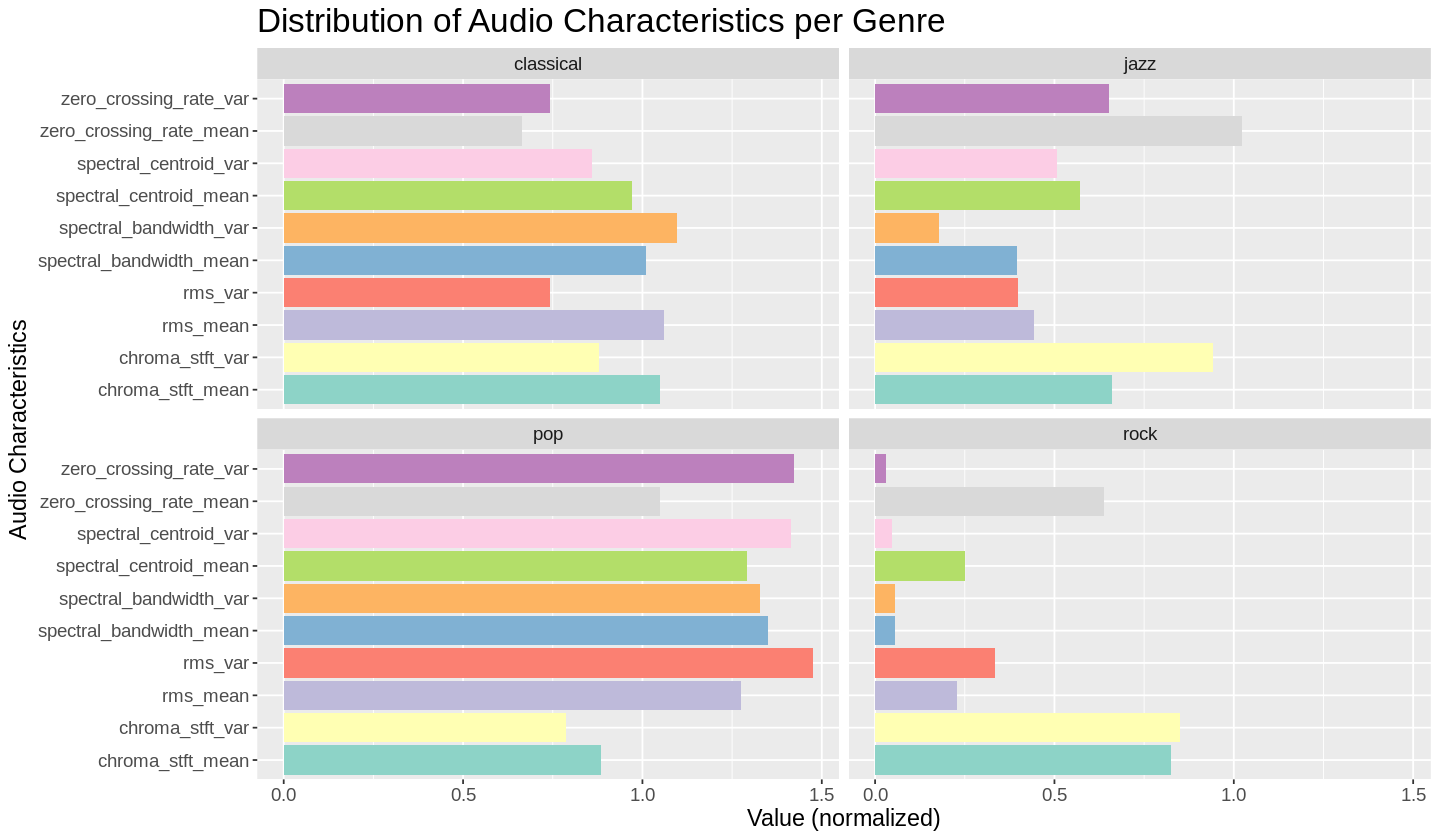

In [6]:
# Visualize the training dataset with a plot.
options(repr.plot.width = 12, repr.plot.height = 7)

music_summary_labels <- music_summary |>
    select(label)

music_summary_norms <- music_summary |>
    select(all_of(VARIABLES)) |>
    mutate(across(everything(), scale)) |>
    mutate(across(everything(), abs))

music_summary_long <- bind_cols(music_summary_labels, music_summary_norms) |>
    pivot_longer(cols = -label, names_to = "name", values_to = "value")

music_visualization <- music_summary_long |>
    ggplot(aes(x = name, y = value, fill = name)) +
        geom_bar(stat = "identity") +
        facet_wrap(~label, ncol = 2) +
        labs(x = "Audio Characteristics", y = "Value (normalized)", title = "Distribution of Audio Characteristics per Genre") +
        theme(legend.pos = "none", plot.title = element_text(size = 20), text = element_text(size = 14)) +
        scale_fill_brewer(palette = "Set3") +
        coord_flip()

music_visualization



We also visualize a few potential grouping pattern that might occur between different predictor variables.

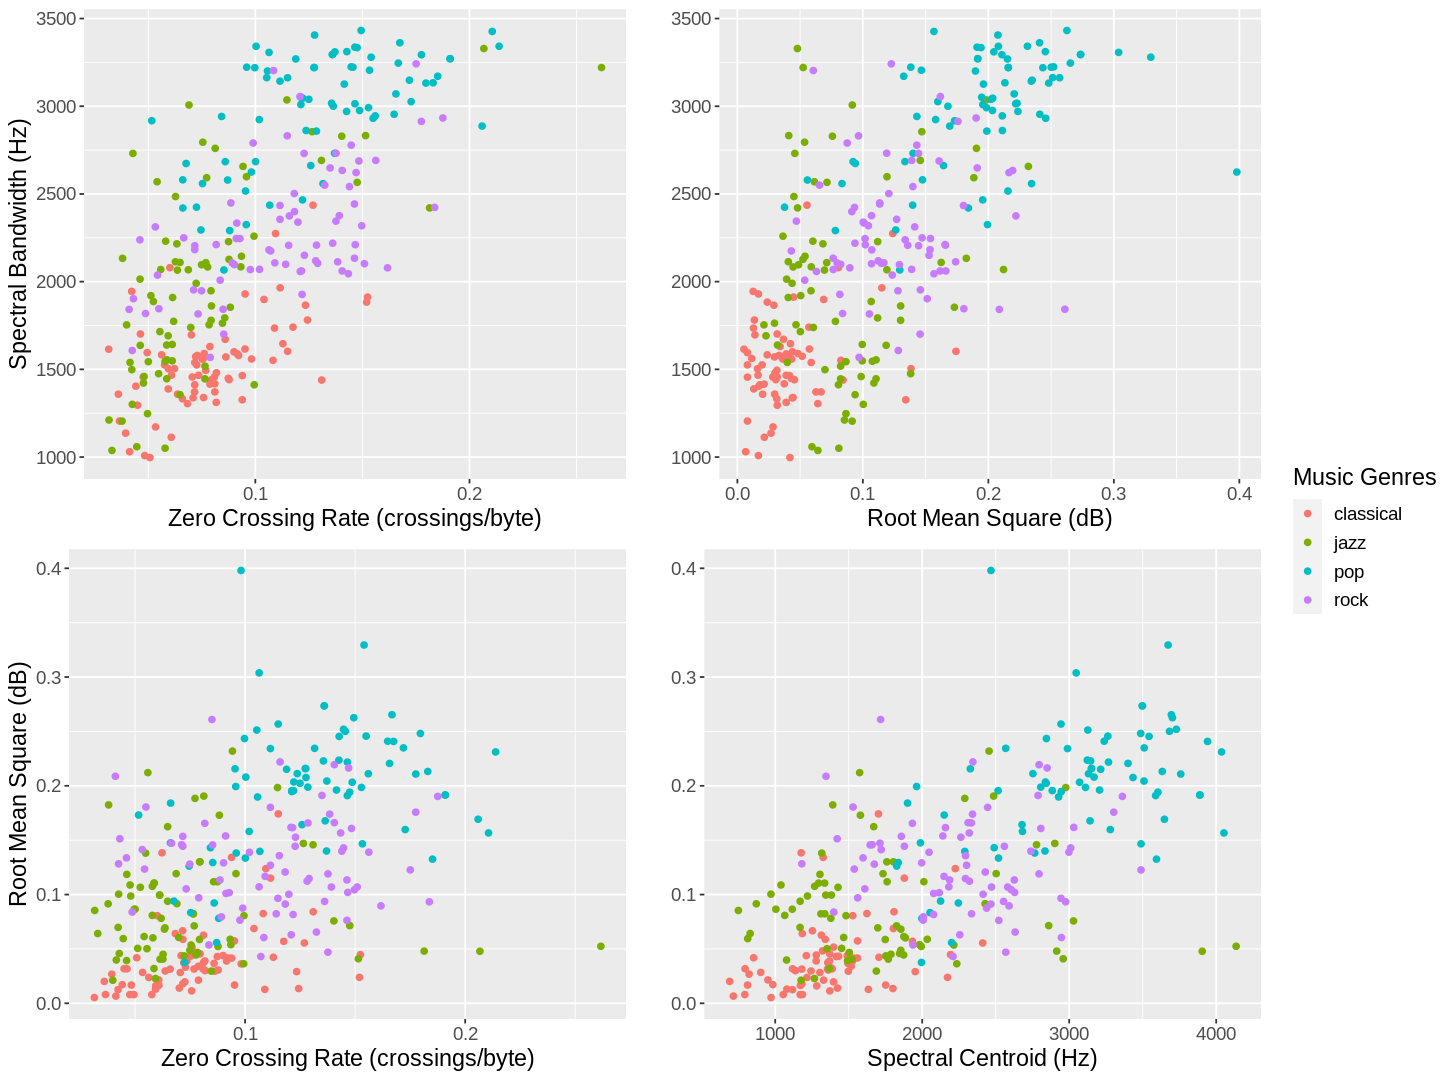

In [7]:
options(repr.plot.width = 8, repr.plot.height = 6)

template <- music_training_data |>
            ggplot(aes(x = zero_crossing_rate_mean, y = spectral_bandwidth_mean, color = label)) +
                geom_point() +
                theme(plot.title = element_text(size = 20), text = element_text(size = 14)) +
                labs(x = "Zero Crossing Rate (crossings/byte)", y = "Spectral Bandwidth (Hz)", color = "Music Genres")

zc_vs_sb <- music_training_data |>
            ggplot(aes(x = zero_crossing_rate_mean, y = spectral_bandwidth_mean, color = label)) +
                geom_point() +
                theme(legend.pos = "none", plot.title = element_text(size = 20), text = element_text(size = 14)) +
                labs(x = "Zero Crossing Rate (crossings/byte)", y = "Spectral Bandwidth (Hz)")

rms_vs_sb <- music_training_data |>
            ggplot(aes(x = rms_mean, y = spectral_bandwidth_mean, color = label)) +
                geom_point() +
                theme(legend.pos = "none", plot.title = element_text(size = 20), text = element_text(size = 14)) +
                labs(x = "Root Mean Square (dB)", y = "")

rms_vs_zc <- music_training_data |>
            ggplot(aes(y = rms_mean, x = zero_crossing_rate_mean, color = label)) +
                geom_point() +
                theme(legend.pos = "none", plot.title = element_text(size = 20), text = element_text(size = 14)) +
                labs(y = "Root Mean Square (dB)", x = "Zero Crossing Rate (crossings/byte)")

rms_vs_sc <- music_training_data |>
            ggplot(aes(x = spectral_centroid_mean, y = rms_mean, color = label)) +
                geom_point() +
                theme(legend.pos = "none", plot.title = element_text(size = 20), text = element_text(size = 14)) +
                labs(x = "Spectral Centroid (Hz)", y = "")

legend <- get_legend(
  # create some space to the left of the legend
  template + theme(legend.box.margin = margin(0, 0, 0, 12))
)

options(repr.plot.width = 12, repr.plot.height = 9)

plots <- plot_grid(zc_vs_sb, rms_vs_sb, rms_vs_zc, rms_vs_sc,
                ncol = 2, nrow = 2)

final_plot <- plot_grid(plots, legend, rel_widths = c(3, .4))

final_plot

## Methods

To classify song genre based on audio features, the data will undergo preprocessing, feature extraction, data exploration, data splitting, model training using the $K$-nearest-neighbors algorithm, model evaluation, 5-fold cross validation and model optimization. To exteact the relevant features from the audio data for model training, we will tune $K$ values as well as performing iterative perdictor variable selection. Finally, we will evaluate its performance against a test set, interpret, and report on the ability to classify genre based on audio features. 

A few useful predictor variables:

1. **Chroma feature:** Measures the distribution of musical pitch, and captures tonal content. Helpful in distinguishing genres that have distinct harmonic patterns.

2. **RMS (Root Mean Square) values:** Measures the perceived loudness of the signal. Useful in differentiating genres with varying loudness characteristics.

3. **Spectral centroid:** easures the average frequency of the signal. Aids in identifying genres that tend to have specific frequency characteristics.

4. **Spectral bandwidth:** Measures the average spread of frequencies of the signal. Helps differentiate genres with varying spectral width or frequency spread.

5. **Zero crossing rate:** Provides information about the signal's fluctuations. Useful in distinguishing genres with different levels of rhythmic complexity or smoothness.


### Visualization
- **Scatter plot:** Plot the audio features of songs as data points on a graph to identify clusters or patterns.
- **Heatmap:** Visualize the correlation between audio features using a matrix of colors.
- **Box plot:** Illustrate the distribution of audio features within genres using boxes and whiskers.

## Expected Outcomes and Significance

### Expected Findings
In general, the project anticipates identifying informative and discriminative features that strongly influence genre classification from the audio spectrograph, enabling a deeper understanding of the distinguishing characteristics of different music genres and providing valuable insights in genre classification based on audio features. 

### Potential Impacts
Overall, the findings can have practical implications in the music industry and related fields, including enhancing music discovery, improving musical analysis, and assisting music production processes. 

### Future Questions
- How does the performance of KNN classification compare to other algorithms for genre classification?

- How can genre classification models handle songs that contain elements of multiple genres or blur genre boundaries?